# Testing Navier-Stokes in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Non-linear term basic calculation

In [3]:
srand(1);

In [4]:
nx = 129; ny = 129;
w = Nodes(Dual,(nx,ny))
w .= rand(size(w));
Qq = Edges(Dual,w);
Ww = deepcopy(Qq);
ψ = deepcopy(w);

In [5]:
L = plan_laplacian(w,with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 129, ny = 129) grid with spacing 1.0

In [7]:
@time nl = divergence(shift!(Qq,curl(L\w))∘shift!(Ww,w));

  0.008727 seconds (20 allocations: 776.844 KiB)


### Solve the Lamb-Oseen vortex

First, construct the exact solution

In [8]:
woseen(x::Tuple{Real,Real},t;Re=1.0,x0::Tuple{Real,Real}=(0,0),t0=1) = 
                            exp(-((x[1]-x0[1])^2+(x[2]-x0[2])^2)/(4(t+t0)/Re))/(1+t/t0)

woseen (generic function with 1 method)

In [9]:
nx = 260; ny = 130;
Re = 200 + 50rand()
U = 1.0 + 0.2randn()
U∞ = (U,0.0)
Lx = 2.0;
Δx = Lx/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re);
w₀ = Nodes(Dual,(nx,ny));

Construct exact solution in shape of grid data

In [10]:
xg,yg = coordinates(w₀,dx=Δx)
x0 = (1.0,1.0); t0 = 1;
wexact(t) = [woseen((x,y),t;Re=Re,x0=x0.+U∞.*t,t0=t0) for x in xg, y in yg]

wexact (generic function with 1 method)

In [11]:
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞)

Navier-Stokes system on a grid of size 260 x 130

In [12]:
ifrk = IFRK(w₀,sys.Δt,
                (t,w) -> Systems.plan_intfact(t,w,sys),
                (w,t) -> Systems.r₁(w,t,sys) ,rk=TimeMarching.RK31)

Order-3 IF-RK integator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,260,130}
   Time step size 0.0078125


In [13]:
t = 0.0
w₀ .= wexact(t)
w = deepcopy(w₀)
tf = 1.0
T = 0:Δt:tf;

In [14]:
t = 0.0;
@time for ti in T
    t, w = ifrk(t,w)
end

 22.802780 seconds (11.81 k allocations: 929.614 MiB, 0.49% gc time)


In [15]:
norm(w-wexact(t),Inf)

0.03048118310047704

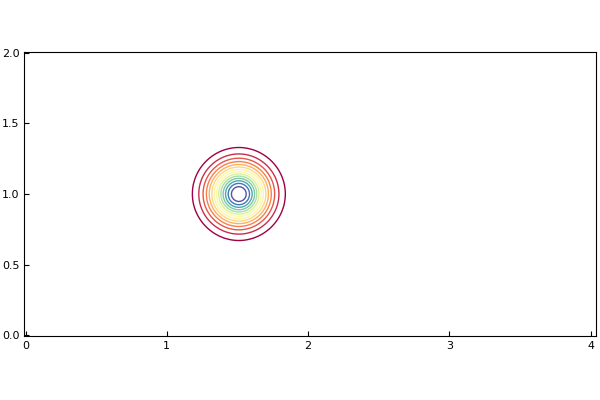

/Users/jeff/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


In [16]:
plot(xg,yg,w)

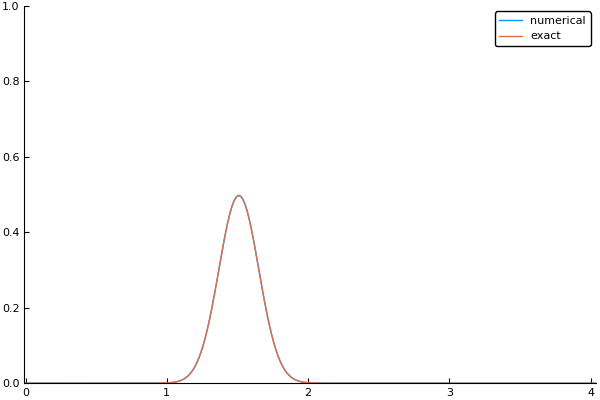

In [17]:
plot(xg,w[:,65],label="numerical",ylim=(0,1))
plot!(xg,wexact(t)[:,65],label="exact")